Reading the images:

1. Upload the picture to the colab's environment.
2. Set the 'path' argument as the picture's name (i.e "clock.jpg").
3. Run all

In [32]:
path = "Change to the image's path"

# **Functions**

In [33]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
from skimage.morphology import skeletonize

In [34]:
def plotCircles(img,circles):
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(img, cmap="gray")
  for i in circles[0,:]:
    circ = plt.Circle((i[0],i[1]), i[2], color='b', linewidth=2, fill=False)
    ax.add_artist(circ)
  ax.title.set_text("Detected Circles")

In [35]:
def crop_image(image, circle):
  # circle(x, y, radius)
  x = int(math.ceil(circle[0][0][0]))
  y = int(math.ceil(circle[0][0][1]))
  r = int(math.ceil(circle[0][0][2]))

  cropped_image = image[(y-r):(y+r), (x-r):(x+r)]
  return cropped_image

In [36]:
def resize_image(image, w=250, h=250):
  cropped_resized_image = cv2.resize(image, (w,h))
  return cropped_resized_image

In [37]:
# https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html
def circles(image):
  circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=200, param2=100, minRadius=50, maxRadius=600)
  return circles



In [38]:
def dist(line):
  return math.sqrt((line[2] - line[0])**2 + (line[3] - line[1])**2)

In [39]:
def centerize_lines(lines):  
  for line in lines:
    x1, y1, x2, y2 = line[0], line[1], line[2], line[3]
    dist1 = dist((x1, y1, 125, 125))
    dist2 = dist((x2, y2, 125, 125))
    if (dist1 < dist2):
      line[0] = 125
      line[1] = 125
    else:
      line[2] = line[0]
      line[3] = line[1]
      line[0] = 125
      line[1] = 125
  return lines

In [40]:
def calculate_angle(line):
  deltaY = line[3] - line[1]
  deltaX = line[2] - line[0]
  angleInDegrees = math.atan2(deltaY, deltaX) * 180 / math.pi
  return (angleInDegrees + 90) % 360

In [41]:
def sort_lines(lines):
  lines = sorted(lines, key=dist, reverse=True)

  return lines

In [42]:
def filter_similar_lines(lines):
  new_lines = []
  lines = sort_lines(lines)

  for line in lines:
    angle1 = calculate_angle(line)
    unique_line = True
    for l in new_lines:
      angle2 = calculate_angle(l)
      if abs(angle1- angle2) < 5 or abs(angle1- angle2) > 355:
        unique_line = False
    if unique_line:
      new_lines.append(line)
  return new_lines


In [43]:
def screen_lines(lines):
  lines = sorted(lines, key=dist, reverse=False)
  new_lines = [lines[0], lines[1]]
  return new_lines

In [44]:
def specify_and_calculate_time(lines):
  if len(lines) >=3:
    return(calculate_time(lines[0], lines[1], lines[2]))
  elif len(lines) == 2:
    return(calculate_time(lines[0], lines[1]))
  else:
    return(calculate_time(lines[0], lines[0]))

In [45]:
def calculate_time(hour_line, minutes_line, seconds_line=None):
  hour_angle = calculate_angle(hour_line)
  minutes_angle = calculate_angle(minutes_line)

  hours = '00'
  minutes = '00'
  seconds = '00'
  # calculate hour
  # np.pi/6

  # Calculate hours
  if 0 <= hour_angle < 30 or (0 <=hour_angle < 35 and minutes_angle > 350):
    hours = '12'
  elif 30 <= hour_angle < 60 or (30 <=hour_angle < 65 and minutes_angle > 350):
    hours = '01'
  elif 60 <= hour_angle < 90 or (60 <=hour_angle < 95 and minutes_angle > 350):
    hours = '02'
  elif 90 <= hour_angle < 120 or (90 <=hour_angle < 125 and minutes_angle > 350):
    hours = '03'
  elif 120 <= hour_angle < 150 or (120 <=hour_angle < 155 and minutes_angle > 350):
    hours = '04'
  elif 150 <= hour_angle < 180 or (150 <=hour_angle < 185 and minutes_angle > 350):
    hours = '05'
  elif 180 <= hour_angle < 210 or (180 <=hour_angle < 215 and minutes_angle > 350):
    hours = '06'
  elif 210 <= hour_angle < 240 or (210 <=hour_angle < 245 and minutes_angle > 350):
    hours = '07'
  elif 240 <= hour_angle < 270 or (240 <=hour_angle < 275 and minutes_angle > 350):
    hours = '08'
  elif 270 <= hour_angle < 300 or (270 <=hour_angle < 305 and minutes_angle > 350):
    hours = '09'
  elif 300 <= hour_angle < 330 or (300 <=hour_angle < 335 and minutes_angle > 350):
    hours = '10'
  elif 330 <= hour_angle < 360 or ((330 <=hour_angle < 360 or 0 <= hour_angle < 5) and minutes_angle > 350):
    hours = '11'
  else:
    'Error'

  # Calculate minutes
  minutes = round(minutes_angle/360 * 60, 2)
  minutes_int = int(minutes)
  minutes_str = str(minutes_int)
  if minutes_int < 10:
    minutes_str = '0' + minutes_str
  
  time = hours + ':' + minutes_str
  # Claculate seconds
  if type(seconds_line) == np.ndarray:
    seconds_angle = calculate_angle(seconds_line)
    seconds = int(seconds_angle / 6)
    seconds_str = str(seconds)
    if seconds < 10:
      seconds_str = '0' + str(seconds)
    time = time + ':' + seconds_str

  return time

In [46]:
# sorting contours by area in a decreasing order
def takeSecond(element):
  return element[1]

def detect_hands(image):
  results = []
  results_lines = []
  lst_hands_thin = []
  # threshold
  # https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html - threshold
  ret, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

  # invert so shapes are white on black background
  # In OpenCV, finding contours detects white objects from black background. 
  thresh = 255 - thresh

  # get contours and save area
  contours_info = []
  # https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html - contours
  contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  # contours = contours[0] if len(contours) == 2 else contours[1]

  index = 0
  # https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html - contour Features
  for contour in contours:
    area = cv2.contourArea(contour)
    # We screens areas which cannot be the hands
    if(area < 2200):
      contours_info.append((index,area))
      index += 1 

  contours_info.sort(key=takeSecond, reverse=True)
  # get largest contour
  # we found out that after resizing, the hands are always with the biggest area that is under 1000
  hands = np.zeros_like(thresh)
  index_first = contours_info[0][0]
  cv2.drawContours(hands, [contours[index_first]], 0, (1), -1)
  hands_thin = skeletonize(hands)
  hands_thin = (255*hands_thin).clip(0, 255).astype(np.uint8)
  lst_hands_thin.append(hands_thin)
  # get hough lines and draw on copy of input
  result = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  lineThresh = 20
  minLineLength = 30
  maxLineGap = 100

  lines = cv2.HoughLinesP(hands_thin, 1, np.pi/180, lineThresh, None, minLineLength, maxLineGap)
  lines = [line[0] for line in lines]
  lines = centerize_lines(lines)
  lines = np.array(lines)
  lines = filter_similar_lines(lines)
  lines = screen_lines(lines)
  lines = sorted(lines, key=dist, reverse=False)
  # results_lines.append(lines)
  
  for line in lines:
    cv2.line(result, (line[0],line[1]), (line[2],line[3]), (0,255,0), 2)

  return lines, result

In [47]:
def time_reader(path):
  image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  circle = circles(image)
  cropped_image = crop_image(image, circle)
  cropped_resized_image = resize_image(cropped_image)
  lines, result = detect_hands(cropped_resized_image)
  time = specify_and_calculate_time(lines)
  return time, result, image

# **Main code**

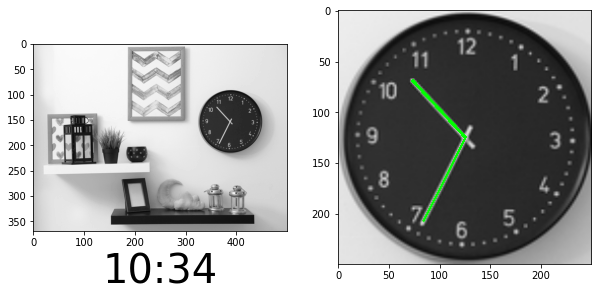

In [49]:
time, result, image = time_reader(path)

_, axes = plt.subplots(1,2,figsize=(10,10))
for ax, img, times in zip(axes.flatten(), [image, result], [time, '']):
  ax.imshow(img, cmap='gray')
  ax.set_xlabel(times, fontsize=40)